#**Redes Neuronales en Keras**
----


Como vimos en la **Unidad 1**, _Keras_ es un paquete que actúa como un _framework_ de alto nivel simplificando todo el flujo de trabajo relacionado a modelos de _Machine Learning_ y _Deep Learning_. En esta unidad exploraremos más a fondo cómo se maneja este flujo de trabajo usando todas las herramientas que _Keras_ tiene a disposición. Veremos:

- Fundamentos de Redes Neuronales Artificiales
  - Perceptrón de Rosenblat
  - Cómo aprender funciones lógicas
- Redes Neuronales en _Keras_
  - Capas o *Layers*
    - Funciones de activación
  - Definición de modelos
    - Modelo secuencial
    - Modelo funcional
  - Flujo de entrenamiento
    - Optimizadores
    - Funciones de pérdida
    - Compilación
  - Evaluación
- Ejemplos de aplicación


Primero importaremos algunos paquetes y definiremos algunas funciones que nos ayudarán a visualizar regiones de decisión :  

In [ ]:
# Importamos las librerías que utilizaremos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
plt.style.use("ggplot")

Definiremos algunas funciones para facilitar la visualización, usaremos estas funciones a lo largo del notebook para comprender los conceptos de redes neuronales :

In [ ]:
# Función para mostrar regiones de decisión
def plot_decision_region(X, y, model):
    plt.figure(figsize=(7,7))
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x)*0.05
    max_x = max_x + (max_x - min_x)*0.05
    min_y = min_y - (max_y - min_y)*0.05
    max_y = max_y + (max_y - min_y)*0.05
    x_1 = np.linspace(min_x, max_x, 100)
    x_2 = np.linspace(min_y, max_y, 100)
    x1,x2 = np.meshgrid(x_1, x_2)
    X_grid = np.concatenate([x1.reshape(-1,1), x2.reshape(-1,1)], axis=1)
    y_pred = model(X_grid).numpy()
    Z = y_pred.reshape(x1.shape)
    plt.contourf(x1, x2, Z, cmap=plt.cm.RdBu, alpha=0.2)
    plt.scatter(X[:,0], X[:,1], c=y, alpha=1.0, cmap=plt.cm.RdBu, s=100)
    plt.xlabel("$x_1$"); plt.ylabel("$x_2$")

# Función para imprimir las predicciones
def print_labels(y_true, y_pred):
    Y1 = y_true.flatten()
    Y2 = y_pred.flatten()
    print("  Valor esperado   Valor predicho  ")
    print("_"*35)
    for y1, y2 in zip(Y1, Y2):
        print(f"|      {y1:.2f}       |       {y2:.2f}      |")

Finalmente, importamos _keras_

In [ ]:
import keras

Seleccionamos las semillas para efectos de reproducibilidad :

In [ ]:
np.random.seed(0)
keras.utils.set_random_seed(0)

# **1. Perceptrón de Rosenblatt**
---

Una de las primeras versiones de red neuronal es el **modelo neuronal de McCulloch y Pitts (1943)**, también conocido como *Threshold Logic Unit* (TLU) o *Linear Threshold Unit*. Se trata de una unidad de cálculo que intenta modelar el comportamiento de una neurona, constituyendo la unidad esencial con la cual se construye una red neuronal artificial o *artificial neural network* (ANN).

El resultado del cálculo en una neurona de este tipo consiste en obtener una combinación lineal (producto punto o suma ponderada) entre un vector de entrada $\vec{x}=(x_1, x_2, \dots, x_n)$ y unos pesos $\vec{w}=(w_1, w_2, \dots, w_n)$ más un sesgo $b$, seguido de la aplicación de una función no lineal o **función de activación** $\phi$:

$$
\phi( \vec{x} \cdot \vec{w} + b).
$$

En 1957 Frank Rosenblatt, un profesor de psicología en la Universidad de Cornell, creó un modelo matemático conocido como el **perceptrón simple**. Se trata de una red neuronal de una capa y una única neurona que puede ser utilizada para el reconocimiento de patrones o tareas de clasificación. Rosenblatt desarrolló un modelo que podía ser entrenado con **aprendizaje supervisado**, es decir, extrayendo patrones de ejemplos etiquetados para aprender a clasificar de forma automática.

El perceptrón simple es una red neuronal que usa una función de activación ***Heaviside*** o de salto unitario, cuya ecuación y gráfica se muestra a continuación:


$$
\begin{align}
    H(\vec{x},\vec{w},\theta)=\left\{\begin{array}{l}
                 1 & \text{si} ~ \vec{x}\cdot\vec{w}+ \theta >0 \\
                 0 & \text{en otro caso}\\
                 \end{array}
       \right.
\end{align}
$$

<center>
<img src="https://drive.google.com/uc?export=view&id=19iKoRD7i-jTK7M89ViACc4eHAVhoeQAK" alt ="Gráfico de la función de activación Heavside" width="50%">
</center>


Por simplicidad en la notación, el término del sesgo $b$ lo llamaremos $w_0$. Entonces $\vec{x}$ será $(x_0, x_1, x_2, \dots, x_n)$ y  $\vec{w}=(w_0, w_1, w_2, \dots, w_n)$. De esta manera, el modelo del perceptrón se puede definir así:

<center>
<img src="https://drive.google.com/uc?export=view&id=1ztvLUkbpS_iQ4xCspI-7xwgLMpHmfXRk" alt="Gráfico de la definición del Perceptrón de Rosenblatt" width="70%">
</center>

$$
\widetilde{y}_i=H(\vec{x},\vec{w},\theta)\\
$$

Veamos un ejemplo del comportamiento de un perceptrón simple en _keras_, comenzamos definiendo el modelo




In [ ]:
# Definimos la función de Heavisisde
def heaviside(x):
    return(keras.ops.sign(x) + 1) / 2

# Definimos el modelo
rosenblatt = keras.models.Sequential(
    [
        keras.Input(shape=(2, )),
        keras.layers.Dense(1, activation=heaviside)
    ]
)

 Definimos una función que calcula el escalon de Heaviside para usar en la construcción del modelo. Para ello usamos `keras.ops.sign`, el cual retorna $1$ o $-1$ según el signo del número que reciba como argumento. Sumando $1$ a la función `keras.ops.sign` y dividiendo el resultado por $2$, obtenemos la función de Heaviside $H$:

## 1.1 Aprendiendo compuertas lógicas

Ahora vamos a ajustar **manualmente** los pesos del modelo para solucionar funciones Booleanas básicas y comprender qué está aprendiendo el perceptrón.

### 1.1.1 AND

Veamos un ejemplo del perceptrón de Rosenblatt. En este caso, lo utilizaremos para aprender la función lógica **AND**, que recibe como entradas dos variables Booleanas $x_1$ y $x_2$ y retorna el valor Booleano $y$.

|$x_1$|$x_2$|$y$|
|---|---|---|
|0|0|0|
|0|1|0|
|1|0|0|
|1|1|1|


A partir de esto podemos definir los datos ($X$, $y$) para entrenar el modelo :

In [ ]:
# Definimos la matriz de observaciones o entradas
X = np.array(
    [
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1]
        ]
    )
print(X)

[[0 0]
 [0 1]
 [1 0]
 [1 1]]


In [ ]:
# Definimos las etiquetas
y_AND = np.array([0, 0, 0, 1])
print(y_AND)

[0 0 0 1]


In [ ]:
# Realizamos las predicciones
y_tilde = rosenblatt(X).numpy()
print(y_tilde)

[[0.5]
 [0. ]
 [1. ]
 [0. ]]


Como puede evidenciarse, no obtuvimos el resultado correcto, pero era de esperarse dado que los pesos del modelo fueron escogidos de forma aleatoria. Ahora, modificaremos los valores de los coeficientes hasta conseguir predecir la función **AND**:

  Valor esperado   Valor predicho  
___________________________________
|      0.00       |       0.00      |
|      0.00       |       0.00      |
|      0.00       |       0.00      |
|      1.00       |       1.00      |


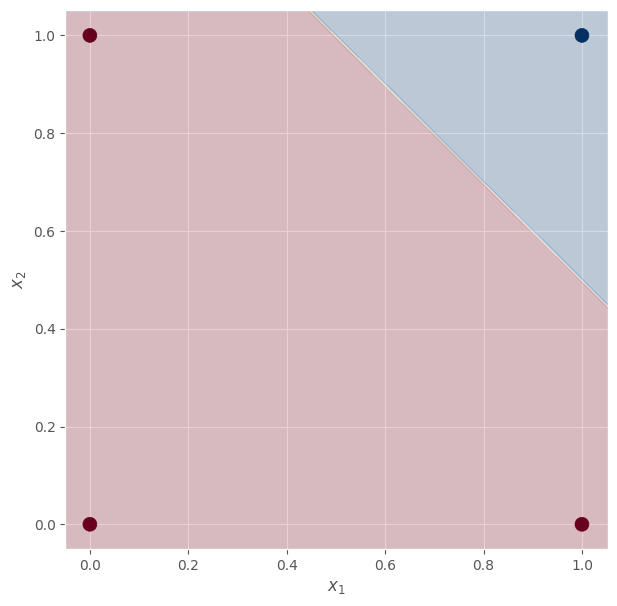

In [ ]:
# Para asignar los pesos use modelo.layer.set_weights
rosenblatt.layers[0].set_weights([np.array([[1],[1]]), np.array([-1.5])])

print_labels(y_AND, rosenblatt(X).numpy())
plot_decision_region(
        X, y_AND,
        rosenblatt
        )

### 1.1.2 Función OR

Ahora, vamos a solucionar el problema **OR**

|$x_1$|$x_2$|$y$|
|---|---|---|
|0|0|0|
|0|1|1|
|1|0|1|
|1|1|1|

In [ ]:
# Definimos la matriz de observaciones
X = np.array(
        [
            [0, 0],
            [0, 1],
            [1, 0],
            [1, 1]
            ]
        )
print(X)

[[0 0]
 [0 1]
 [1 0]
 [1 1]]


In [ ]:
# Definimos las etiquetas
y_OR = np.array([0, 1, 1, 1])
print(y_OR)

[0 1 1 1]


In [ ]:
# Definimos el modelo
rosenblatt = keras.models.Sequential(
    [
        keras.Input(shape=(2, )),
        keras.layers.Dense(1, activation=heaviside)
    ]
)
# Realizamos las predicciones
y_tilde = rosenblatt(X).numpy()
print(y_tilde)

[[0.5]
 [0. ]
 [0. ]
 [0. ]]


Ahora, modificaremos los pesos hasta conseguir predecir la función **OR**:

  Valor esperado   Valor predicho  
___________________________________
|      0.00       |       0.00      |
|      1.00       |       1.00      |
|      1.00       |       1.00      |
|      1.00       |       1.00      |


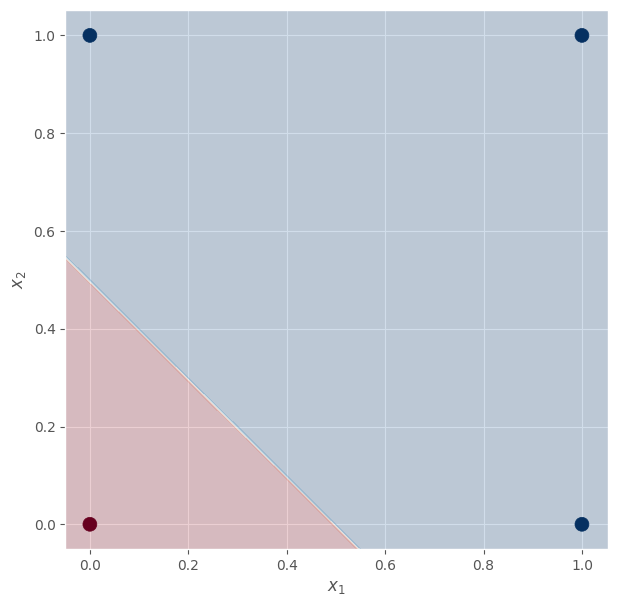

In [ ]:
# Para asignar los pesos use modelo.layer.set_weights
rosenblatt.layers[0].set_weights([np.array([[1],[1]]), np.array([-0.5])])

print_labels(y_OR, rosenblatt(X).numpy())
plot_decision_region(
        X, y_OR,
        rosenblatt
        )

### 1.1.3 Función XOR

Ahora, intentemos solucionar el problema **XOR** con el perceptrón simple

|$x_1$|$x_2$|$y$|
|---|---|---|
|0|0|0|
|0|1|1|
|1|0|1|
|1|1|0|

In [ ]:
# Definimos la matriz de observaciones
X = np.array(
        [
            [0, 0],
            [0, 1],
            [1, 0],
            [1, 1]
            ]
        )
print(X)

[[0 0]
 [0 1]
 [1 0]
 [1 1]]


In [ ]:
# Definimos las etiquetas
y_XOR = np.array([0, 1, 1, 0])
print(y_XOR)

[0 1 1 0]


In [ ]:
# Definimos el modelo
rosenblatt = keras.models.Sequential(
    [
        keras.Input(shape=(2, )),
        keras.layers.Dense(1, activation=heaviside)
    ]
)
# Realizamos las predicciones
y_tilde = rosenblatt(X).numpy()
print(y_tilde)

[[0.5]
 [0. ]
 [1. ]
 [0. ]]


Intentaremos modificar los pesos hasta conseguir predecir la función **XOR**.

  Valor esperado   Valor predicho  
___________________________________
|      0.00       |       1.00      |
|      1.00       |       1.00      |
|      1.00       |       0.00      |
|      0.00       |       1.00      |


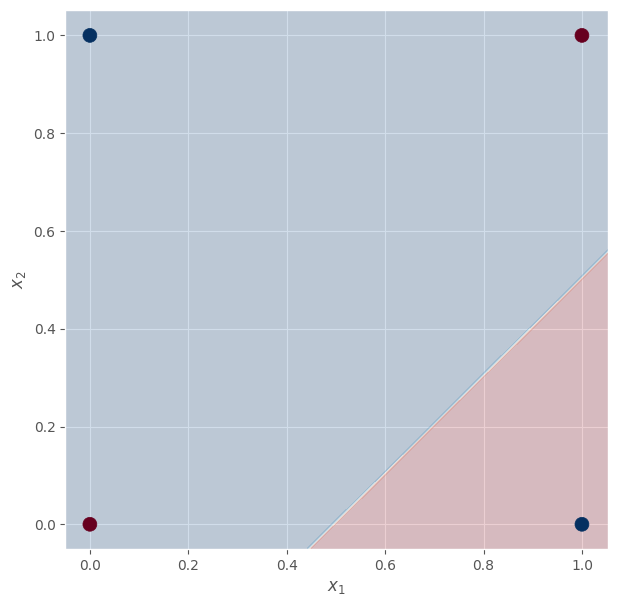

In [ ]:
# Para asignar los pesos use modelo.layer.set_weights
rosenblatt.layers[0].set_weights([np.array([[-1],[1]]), np.array([0.5])])

print_labels(y_XOR, rosenblatt(X).numpy())
plot_decision_region(
        X, y_XOR,
        rosenblatt
        )

En este caso la predicción falla, el perceptrón simple **NO** es capaz de resolver el problema **XOR**. La principal razón por la que el perceptrón simple falló (y por la que siempre fallará) es porque el problema **XOR** es un problema donde los puntos no son linealmente separables. Es decir, si lo vemos de forma gráfica, no es posible trazar una recta que separe por completo las dos clases, y es que el perceptrón simple precisamente, solo tiene capacidad para encontrar un hiperplano como frontera de separación entre las dos categorías.

# **2. Redes Neuronales en Keras**
---

<center>
<img src="https://drive.google.com/uc?export=view&id=1PTlZrJ2m0s2mfFPzR365VKAeGl82Bh5J" width="50%">
</center>

Actualmente, _Keras_ es una de las herramientas principales para el desarrollo de modelos profundos. Permite diseñar de forma rápida arquitecturas de _*Deep Learning*_, cargar y guardar modelos, provee varias redes de propósito general y es totalmente compatible con varias librerias como: _Tensorflow_, _PyTorch_ y _JAX_. `keras` provee varios módulos con los componentes fundamentales para diseñar una red neuronal. La idea es construir un modelo a partir de los siguientes elementos: _**capas, optimizador y funciones de pérdida**_.


## **Red neuronal multicapa**

El **perceptrón multicapa o red neuronal multicapa** es una generalización del perceptrón que incluye varias neuronas organizadas en varias capas como se muestra en la siguiente figura :

<center><img src="https://drive.google.com/uc?export=view&id=16HuPzZdyHkjaLgZ-VAYdMR4Dxha3IlFn" alt ="Diagrama de una Red Neuronal Multicapa" width="70%"></center>

Se trata de un tipo de modelo que tiene un mayor número de parámetros pero que permite solucionar problemas que no son linealmente separables (la cual es la principal limitación del perceptrón simple). **Las redes neuronales profundas (*deep*) son básicamente redes multicapa con alto número de capas.**

El entrenamiento de las redes neuronales multicapa se basan fundamentalmente en un algoritmo conocido como _**Back-propagation**_, en el cual se aprovechan las propiedades de la derivada (fundamentalmente la regla de la cadena) y algoritmos de optimización basados en gradiente descendente para determinar los parámetros de la red.


<center><img src="https://drive.google.com/uc?export=view&id=1BCM7QGQm5Lvph6mmLdsrbLmqGc-SPwVh" alt ="Gif explicativo del algoritmo de Back-Propagation" width="60%"></center>

El objetivo al final siempre será optimizar una función de costo (o función de pérdida) **de forma iterativa**.

<center><img src="https://drive.google.com/uc?export=view&id=16lFqMt2RCd5XokkplvCSuak_m07XqM08" alt ="Diagrama explicativo de un Gradiente Descendente" width="50%"></center>

Las redes neuronales multicapa pueden ser fácilmente construidas utilizando _**Keras**_, como se mostrará a continuación.

## 2.1 Proceso General

Veamos un ejemplo de cómo entrenar una red multicapa para solucionar de nuevo el problema **XOR**. De paso veremos cómo es el proceso general para utilizar _Keras_:

In [ ]:
# Definimos la matriz de observaciones o muestras de entrada
X = np.array(
        [
            [0, 0],
            [0, 1],
            [1, 0],
            [1, 1]
            ]
        )
print(X)

[[0 0]
 [0 1]
 [1 0]
 [1 1]]


In [ ]:
# Definimos las etiquetas o valores de salida
y_XOR = np.array([0, 1, 1, 0])
y_XOR

array([0, 1, 1, 0])

Usaremos una capa `keras.layers.Dense`. Recordemos cuáles son los argumentos necesarios para definirla :

*   `units`: Un número entero que define el número de neuronas de la capa.
*   `input_shape`: Una tupla con la dimensión de los datos de entrada.
*   `activation`: Una función de activación que se aplica a la salida de la capa.

Puede ser que no definamos una función de activación dentro de `keras.layers.Dense`. En ese caso, **es equivalente** usar `keras.layers.Activation` para definir la activación después de definir la capa densa, como sucede a continuación:


Veamos más en detalle:

- La primera instrucción (`keras.models.Sequential`) crea un modelo de tipo secuencial, es decir un modelo estructurado en diferentes capas de procesamiento (*layers*) organizadas de manera secuencial.

Luego, las capas se definen en una lista que se pasa como argumento a `keras.models.Sequential`:

- Se agrega una capa de neuronas *densamente* conectadas con las 2 entradas (`keras.layers.Dense(units = 16, ...`) y con una función de activación _sigmoide_ (`keras.layers.Activation("sigmoid")`).

- Luego se agrega la capa de salida constituida por dos neuronas con una función de activación _softmax_ (`keras.layers.Dense(2, activation="softmax")`).

In [ ]:
# Definimos el modelo
model_seq = keras.models.Sequential(
    [
        keras.Input(shape=(2, )),                     # El input es de tamaño (2, )
        keras.layers.Dense(units = 16                 # Primera capa de 16 neuronas
                              ),                         # No definimos función de activación
        keras.layers.Activation("sigmoid"),           # Función de activación "sigmoid" como una capa aparte
        keras.layers.Dense(2, activation="softmax")   # Salida: Capa de dos neuronas con activación softmax
    ]
)

> **¿Cómo es mejor definir la función de activación? ¿Dentro de `keras.layers.Dense'? O ¿Usando `keras.layers.Activation`?**
> Desde el punto de vista del cómputo, es igual. Sin embargo, `keras.layers.Activation` ofrece mayor flexibilidad modular, es decir, permite controlar directamente la función, por ejemplo en caso de querer hacer alguna edición sobre la arquitectura del modelo.

Una vez definido el modelo, _Keras_ nos permite ver un resumen de la arquitectura, con detalles como el nombre de cada capa de neuronas, las activaciones, la dimensión de la salida en cada capa, y el número de parámetros asociados, usando el método `summary()`:


In [ ]:
model_seq.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82 (328.00 B)

 Trainable params: 82 (328.00 B)

 Non-trainable params: 0 (0.00 B)

En este momento los 82 parámetros del modelo tienen valores de inicialización aleatorios. Es decir, el modelo lo podemos usar para hacer predicciones, pero muy seguramente van a ser erróneas :

In [ ]:
model_seq.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


array([[0.88753086, 0.11246919],
       [0.8807566 , 0.11924338],
       [0.8858273 , 0.11417273],
       [0.8795277 , 0.12047227]], dtype=float32)

Nuestro modelo tiene una capa de salida de dos neuronas. Es decir, cada predicción arroja dos valores: la probabilidad de que la etiqueta sea $0$ y la probabilidad de que la etiqueta sea $1$. En este caso, el modelo está prediciendo todo hacia una sola etiqueta, es decir, no está haciendo nada interesante; **hay que entrenarlo**.

Para entrenar el modelo hay que definir primero, por lo menos, una **función de pérdida** y un **optimizador**. Eso lo hacemos con la función `compile`. En este caso usaremos

*   `keras.losses.CategoricalCrossentropy` como función de pérdida, y
*   `keras.optimizers.Adam` como optimizador. Aquí además debemos definir un hiper-parámetro muy importante: el **_learning rate_** o tasa de aprendizaje. Usaremos un `learning_rate` de $0.1$.

Más adelante en este notebook veremos en detalle las funciones de pérdida y los optimizadores.




In [ ]:
model_seq.compile(loss=keras.losses.CategoricalCrossentropy(),
                  optimizer=keras.optimizers.Adam(learning_rate = 1e-3)
                  )

Como la capa de salida del modelo que definimos tiene dos neuronas, una por cada clase, necesitamos una codificación *one-hot* para las etiquetas de los datos.

Usamos la función `keras.ops.one_hot` sobre las etiquetas:

In [ ]:
Y = keras.ops.one_hot(y_XOR, num_classes=2)
print(Y)

tf.Tensor(
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]], shape=(4, 2), dtype=float32)


Con lo anterior, ahora sí podemos entrenar el modelo con la función `fit`, que como argumentos recibe los datos de entrenamiento, y el número de iteraciones o `epochs` del proceso de optimización. El método `fit` que entrena el modelo retorna además un objeto `History` que guarda toda la información del entrenamiento a manera de diccionario. Vamos a guardar todos estos datos de entrenamiento en `hist` para poder hacer rápidamente gráficas del comportamiento de la función de pérdida.

In [ ]:
hist = model_seq.fit(x=X,
                     y=Y,
                     epochs=500)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.1361
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.1281
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 1.1202
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.1124
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 1.1046
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.0969
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.0892
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 1.0816
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.0740
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 1.0665
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.0591
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.0517
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.0444
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.0372
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.0300
Epoch 16/500
1/1 ━━━

Y podemos hacer predicciones con la función `predict`:

In [ ]:
model_seq.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


array([[0.5226979 , 0.47730207],
       [0.49789146, 0.5021086 ],
       [0.4995677 , 0.50043225],
       [0.48048303, 0.519517  ]], dtype=float32)

In [ ]:
# Calculamos en qué índice está la probabilidad más alta para obtener una predicción concreta de la etiqueta
np.argmax(model_seq.predict(X), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([0, 1, 1, 1])

El modelo predice `[0, 1, 1, 0]`, como se esperaba.

En `hist` queda almacenada la información del valor de la función de pérdida `loss`. Directamente con `matplotlib.pyplot` podemos graficar la curva:

Text(0, 0.5, 'Pérdida')

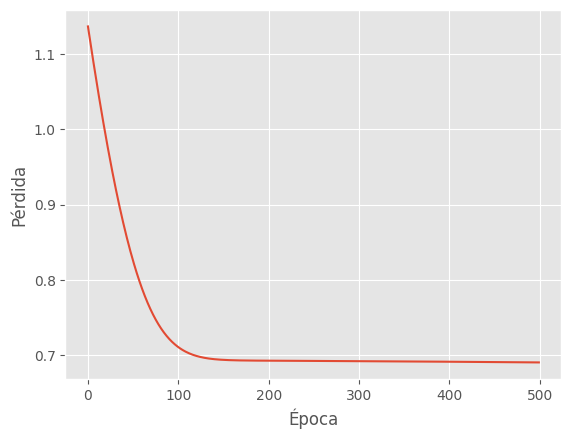

In [ ]:
# Veamos la función de pérdida
plt.plot(hist.history["loss"])
plt.xlabel("Época")
plt.ylabel("Pérdida")

Y como es de esperar, la función de pérdida baja a medida que pasan las _epochs_.

## 2.2 Capas - *Layers*

Los objetos centrales de _Keras_ son las capas o *Layers* y (como pudimos ver en la sección anterior) estos serán los bloques de construcción básicos de los modelos de red neuronal. _Keras_ trae una serie de capas de uso general en el paquete `keras.layers`. Cada capa define automáticamente los pesos y puede aplicar directamente una **función de activación**. Algunos ejemplos de *layers* son:

* `keras.layers.Input`: Es la capa de entrada del modelo. Siempre es necesaria. Aquí definimos la dimensión de los datos.
* `keras.layers.Dense`: Es una capa de neuronas totalmente conectada. Es decir, todas las neuronas de esta capa se conectan con todas las salidas de la capa anterior, y todas las entradas de la capa siguiente (a menos que sea la capa de salida).
* `keras.layers.Activation`: Permite aplicar una función de activación. Estas pueden ser `softmax`, `relu`, `tanh`, `sigmoid`, `linear`, entre otras.
* `keras.layers.Dropout`: Se trata de una capa de regularización, consiste en establecer al azar una fracción de unidades de la entrada a 0 en cada actualización durante la fase de entrenamiento (ayuda a evitar el **sobreajuste**).
* `keras.layers.Convolution2D`: Se trata de una capa convolucional, comúnmente usada en el análisis de imágenes.

_***Nota: Otros tipos de capas se encuentran en el paquete***_ [`keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers).

Salvo `Input`, todas estas capas implementan alguna operación sobre los datos de entrada. En este momento las capa que más nos interesa es `Dense`. Esta implementa la operación: `output = activation(dot(input, kernel) + bias)` donde `activation` es la función de activación elemento a elemento pasada como argumento de activación, `kernel` es la matriz de pesos (que luego se aprenden durante el entrenamiento) creada por la capa, y `bias` es el vector de sesgo creado por la capa (sólo aplicable si `use_bias` es `True` (que es de hecho, la opción por defecto)). Todos estos son atributos de `Dense`.

Veamos por ejemplo un modelo que recibe vectores de tamaño 2, que luego pasan a través de una capa densa de tamaño 8 con activación `softmax`:


In [ ]:
# Creamos un modelo para el ejemplo:
model_a = keras.models.Sequential(
    [
      keras.Input(shape=(2,)),                      # La entrada es de tamaño 2
      keras.layers.Dense(8, activation='softmax')   # Agregamos una capa densa de tamaño 8 con activación softmax
    ]
)

model_a.output_shape    # Verificamos el tamaño de la salida

(None, 8)

Efectivamente el tamaño de la salida es de 8. Veamos cuántos parámetros tiene este modelo:

In [ ]:
model_a.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 8)                   │              24 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24 (96.00 B)

 Trainable params: 24 (96.00 B)

 Non-trainable params: 0 (0.00 B)

Son $24$ parámetros en total. Como la entrada es de tamaño $2$, y la capa densa tiene $8$ neuronas, eso suma $2\times8=16$ conexiones. Pero la capa densa por defecto incluye un sesgo o `bias`. Esto es equivalente a que el tamaño de la capa de entrada sea $3$, y entonces: $(2+1)\times8=24$.

Veamos también las predicciones del modelo para la primera muestra del conjunto `X`:

In [ ]:
model_a(X[:1]).numpy()

array([[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]],
      dtype=float32)

En efecto la salida de la capa es de tamaño 8. Esta capa puede entonces servir como entrada a otra capa densa (o a cualquier capa de _Keras_, guardando los requerimientos necesarios), y de esa manera se construyen modelos cada vez más complejos, por ejemplo:

In [ ]:
# Creamos un modelo para el ejemplo:
model_2dense = keras.models.Sequential(
    [
      keras.Input(shape=(2,)),                      # La entrada es de tamaño 2
      keras.layers.Dense(8, activation='softmax'),  # Agregamos una capa densa de tamaño 8 con activación softmax
      keras.layers.Dense(8, activation='softmax')   # Agregamos una capa densa de tamaño 8 con activación softmax
    ]
)
model_2dense.output_shape                                          # Verificamos el tamaño de la salida

(None, 8)

In [ ]:
model_2dense.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 8)                   │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 8)                   │              72 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96 (384.00 B)

 Trainable params: 96 (384.00 B)

 Non-trainable params: 0 (0.00 B)

El modelo anterior ya tiene 96 parámetros. La segunda capa densa aporta 72 parámetros que se explican por 8 neuronas de entrada, más el `bias`, por 8 neuronas de salida: $(8+1)\times8 = 72$.

## 2.3 Función de activación

El perceptrón simple utilizaba una función _heaviside_ para realizar una predicción. En contraste, en un **perceptrón multicapa** se pueden utilizar distintas activaciones (siempre y cuando sean diferenciables). _keras_ nos ofrece una capa de activación `keras.layers.Activation` que recibe como argumento la función específica que uno defina. Algunas de las funciones de activación más usadas son :

|Nombre|Expresión|Keras|
|---|---|---|
|<img width=100/>|<img width=100/>|<img width=100/>|
|Sigmoid|$\frac{1}{1+e(-x)}$| `'sigmoid'`|
|Tanh|$\text{tanh}(x)$| `'tanh'`|
|ReLU|$\max\{0,x\}$| `'relu'`|
|SoftMax|$\frac{e^{x_i}}{\sum_{j=1}^{l}e^{x_j}}$|`'softmax'`|

La función de activación _SoftMax_ es una activación especial que es comúnmente utilizada en la salida de los modelos. Se trata de una función que convierte la salida del modelo en valores susceptibles de interpretarse como la probabilidad de que una observación pertenezca cada una de las categorías posibles.

_***Nota: Otros tipos de activación se pueden consultar en el paquete***_ [`keras.activations`](https://keras.io/api/layers/activations/).


Veamos más a detalle la función _SoftMax_. Podemos programarla:

In [ ]:
def my_softmax(x):
    return keras.ops.exp(x)/keras.ops.sum(keras.ops.exp(x))

Y calcularla sobre un vector, por ejemplo `[1,2,3]`:

In [ ]:
x = np.array([1., 2., 3.])
my_softmax(x)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.09003057, 0.24472847, 0.66524096])>

Facilmente podemos comprobar que _SoftMax_ convirtió el vector en uno nuevo, en donde la suma de los componentes es igual a $1$:

In [ ]:
print(np.sum(my_softmax(x)))

1.0


Esta misma función la tenemos directamente disponible en _keras_ como `keras.activations.softmax`:

In [ ]:
x = np.array([1., 2., 3.])
keras.activations.softmax(x)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.09003057, 0.24472847, 0.66524096])>

Y también podemos definirla como una capa dentro de un modelo, por ejemplo:

In [ ]:
# Creamos un modelo para el ejemplo:
model_b = keras.models.Sequential(
    [
      keras.Input(shape=(2,)),            # La entrada es de tamaño 2
      keras.layers.Dense(8),              # Agregamos una capa densa de tamaño 8
      keras.layers.Activation(my_softmax) # Agregamos una capa de función de activación softmax
    ]
)
model_b.output_shape                               # Verificamos el tamaño de la salida

(None, 8)

Note que `keras.layers.Activation` nos permite usar funciones definidas propias definidas por nosotros. De nuevo veamos las predicciones de este modelo para la primera muestra del conjunto de datos `X`:

In [ ]:
model_b(X[:1]).numpy()

array([[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]],
      dtype=float32)

**Nota:** los modelos `model_a` y `model_b` son equivalentes. Definir una función de activación dentro del _layer_ (`keras.layers.Dense(8, activation='softmax')`) es igual a definir la capa sin activación (`keras.layers.Dense(8)`) e inmediatamente después definir la capa de activación (`keras.layers.Activation('softmax')`).  


## 2.4 Modelos

Hay dos formas en las que se puede definir un modelo en `keras`, **la forma secuencial y la forma funcional**:

<center><img src="https://drive.google.com/uc?export=view&id=1Rvzz7NcvFrTLGlJUoQdS8dYD30yzPOaR" alt ="Diagrama ilustrativo del concepto inicial de un Modelo secuencial y un Modelo funcional" width="70%"></center>




### 2.4.1 Secuencial

`keras.models.Sequential` es la forma más simple de definir un modelo y sólo sirve para modelos secuenciales, es decir, modelos en donde cada capa recibe únicamente como entrada la salida de la capa que se haya definido anteriormente. La sintaxis general es por tanto muy simple: hay que listar las capas una tras otra dentro de la función `keras.models.Sequential`, es decir: `keras.models.Sequential([Layer1, Layer2, ...])` Este tipo de modelo fue el que ya usamos en la Sección 2.1 (y de hecho en todos los ejemplos anteriores):

In [ ]:
model_seq = keras.models.Sequential(
    [
        keras.layers.Dense(units = 16, input_shape=(2, )),
        keras.layers.Activation("sigmoid"),
        keras.layers.Dense(2, activation="softmax")
    ]
)


Veamos en detalle otro ejemplo más de un modelo secuencial. Primero tenemos que definir el modelo, usando la función `keras.models.Sequential()`. El modelo lo llamaremos `model_seq`:

In [ ]:
model_seq = keras.models.Sequential()

Luego de definirlo, podemos agregarle capas al modelo. Vamos a agregar dos capas densas, la primera compuesta por 64 neuronas con una función de activación _ReLU_. Recordemos que _ReLU_ es una abreviación de _Rectifier Linear Unit_, y está definida por:
$$
f(x)=\max\{0,x\},
$$
es decir, es una función que filtra valores negativos.
La capa la agregamos con la función `add()` aplicada sobre `model_seq`:

In [ ]:
model_seq.add(
    keras.layers.Dense(
        units=64,
        input_shape=(100,),
        activation="relu"
        )
    )

Finalmente agregamos la capa de salida, otra capa densa de dos neuronas con una activación _SoftMax_:

In [ ]:
model_seq.add(
    keras.layers.Dense(
        units=2,
        activation="softmax")
    )

Y podemos vizualizar el modelo con la función `summary()`

In [ ]:
model_seq.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,594 (25.76 KB)

 Trainable params: 6,594 (25.76 KB)

 Non-trainable params: 0 (0.00 B)

También podemos usar la función `plot_model` para tener una vista diagramática del modelo. La función recibe como argumentos el modelo, y la variable Booleana `show_shapes` para mostrar el tamaño de la entrada y la salida de cada capa:

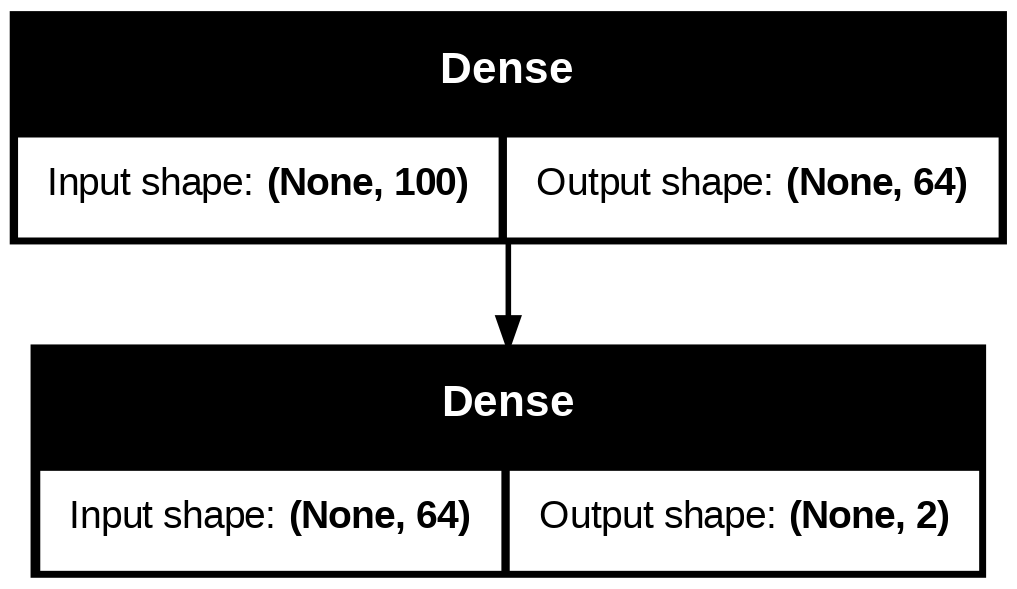

In [ ]:
keras.utils.plot_model(model_seq, show_shapes=True)

### 2.4.2 Funcional

`keras.models.Model` se trata del API funcional de `keras` y nos permite definir modelos de una forma más flexible, es decir, tenemos más control sobre la conexión entre capas, que ya no debe ser necesariamente secuencial. Esto permite por ejemplo que hagamos saltos entre capas, concatenación u operaciones matemáticas entre capas, o construir modelos con múltiples entradas y salidas. Por ejemplo, si queremos concatenar la salida de dos capas, podemos usar la función `keras.ops.concat`, que recibe como argumento una lista con las capas que queremos concatenar.


**Vamos a construir la siguiente arquitectura de red neuronal como ejemplo mientras discutimos cada componente de _Keras_ :**

<center><img src="https://drive.google.com/uc?export=view&id=1tD6dZPx45BjkGwXMxpsjQTe4fvmfnEB2" alt ="Ejemplo de diagrama que ilustra la arquitectura de red a construir" width="60%"></center>

Comencemos creando las capas de la arquitectura:

In [ ]:
# Definimos las dos neuronas de entrada
inp_layer = keras.layers.Input(shape=(2,))
# Definimos la neurona intermedia
int_layer = keras.layers.Dense(units=1,
                                  activation="tanh")
# Definimos la neurona de salida
out_layer = keras.layers.Dense(units=1,
                                  activation="sigmoid")

Note que en la capa `int_layer` usamos la activación _Tangente Hiperbólico_, que devuelve siempre un valor entre $-1$ y $1$. Aparte de introducir una *no-linealidad* en el modelo, esta activación permite controlar la magnitud de los valores que salen de las neuronas sobre las que actúa :

<center><img src="https://drive.google.com/uc?export=view&id=1z-mSU2ueBCK2vAepyAkcKXmxR8iy5pe9" alt = "Gráfica de la Tangente hiperbólica" width="60%"></center>


Sigamos construyendo el modelo; un aspecto muy importante del modelo funcional es que nos permite hacer conexiones explicitas entre las capas :

In [ ]:
# Conectamos la neurona intermedia con la capa de entrada
int_out = int_layer(inp_layer)
# Conectamos la capa de salida con la neurona intermedia y la capa de entrada
y_prime = out_layer(
        keras.layers.Concatenate(axis=1)([inp_layer, int_out],)
        )

Y luego de eso definimos el modelo con `keras.models.Model()`, función que recibe dos argumentos:


*   `inputs`: una lista con las capas de entrada, en este caso solamente `inp_layer`.
*   `outputs`: una lista con las capas de salida, en este caso `y_prime`.



In [ ]:
# Definimos el modelo
model_fun = keras.models.Model(
        inputs=[inp_layer],
        outputs=[y_prime]
        )
# Y de nuevo podemos visualizarlo:
model_fun.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 1)              │              3 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3)              │              0 │ input_layer_11[0][0],  │
│                           │                        │                │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 1)              │              4 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7 (28.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

Hagamos el diagrama y comparémoslo con el modelo secuencial de la Sección 2.4.1:

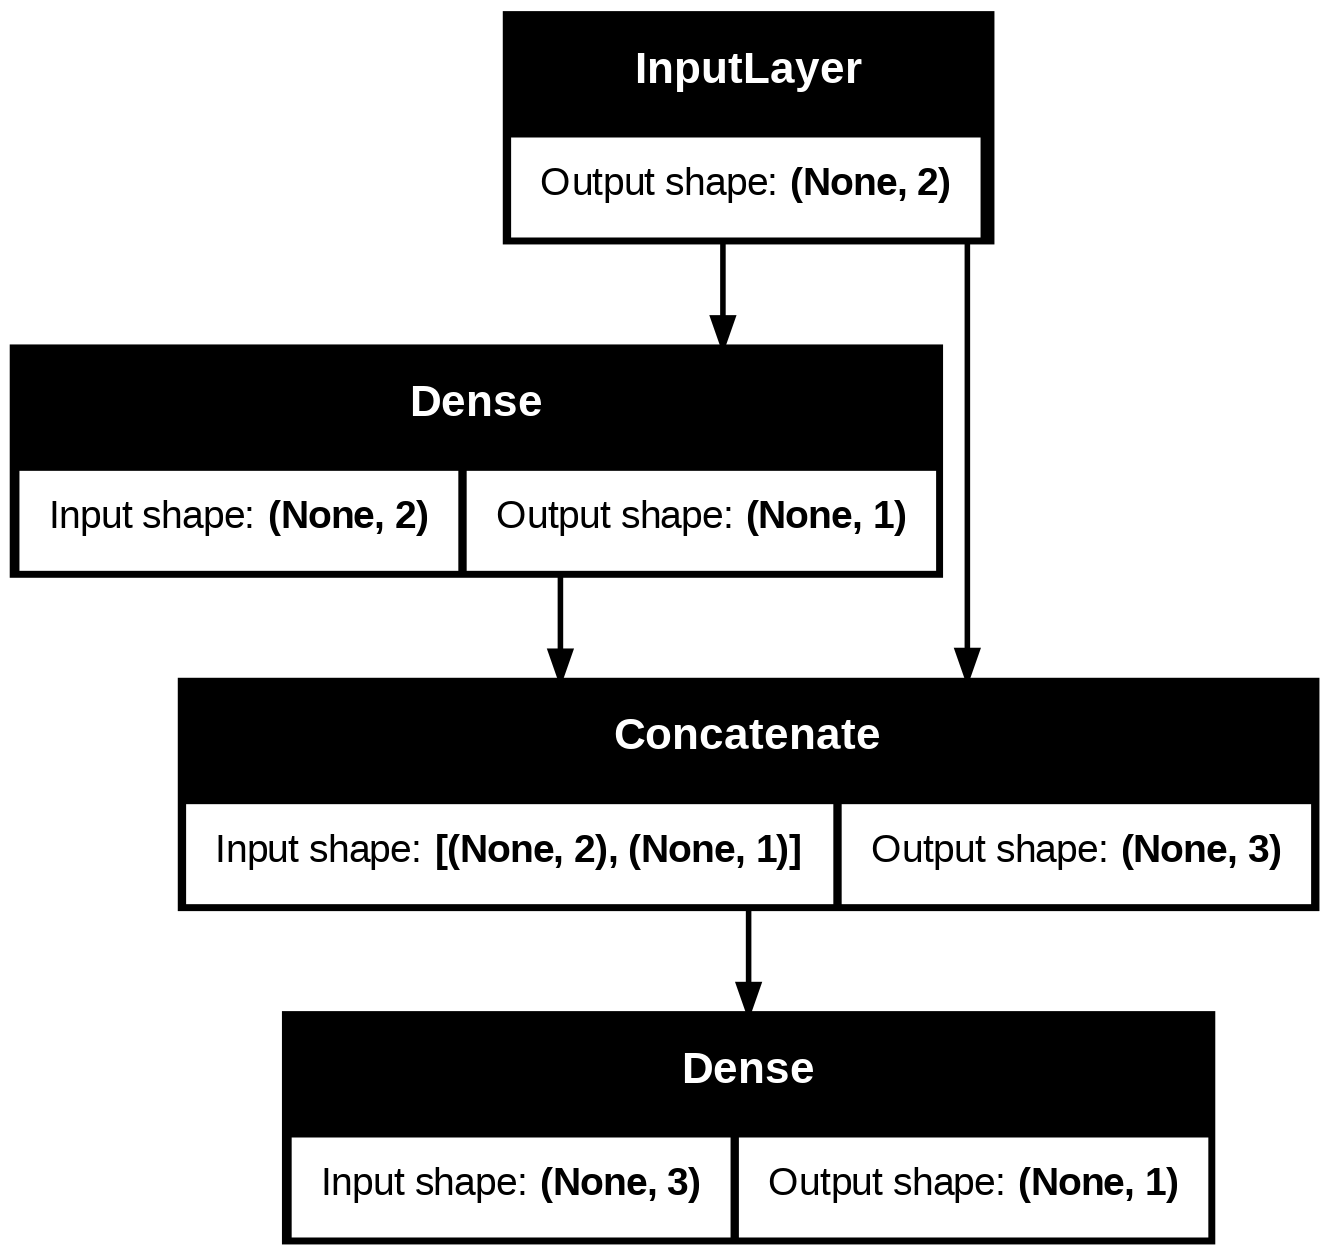

In [ ]:
keras.utils.plot_model(model_fun, show_shapes=True)

En conclusión, la forma funcional permite crear modelos con arquitecturas más complejas, donde el flujo de la información no es necesariamente lineal.

<center><img src="https://drive.google.com/uc?export=view&id=18fKRa1yjrj2_tRD_g9T-fVM74KwygBFD" alt ="Esquema ilustrativo del funcionamiento de un modelo secuencial y un modelo funcional" width="60%"></center>

Los modelos de `keras` tienen métodos como `summary`, `get_config` o `to_json` que proveen información básica de la arquitectura (número de capas, número de parámetros, conexiones, entre otros). Además, contienen métodos como `load_weights` y `save_weights` para cargar y guardar un modelo en formato hdf5.





## 2.5 Optimizadores

`keras` requiere un optimizador para entrenar la red neuronal. Podemos utilizar los optimizadores ya implementados, como:

* _Stochastic Gradient Descent_ (`keras.optimizers.SGD`).
* _Root Mean Square prop_ (`keras.optimizers.RMSprop`)
* _Adaptative Gradient Algorithm_ (`keras.optimizers.Adagrad`)
* _Adaptive Moment estimation_ (`keras.optimizers.Adam`)
* _Adaptive Learning Rate Method_ (`keras.optimizers.Adadelta`)

Para nuestro caso, utilizaremos un optimizador Adam. Todos los optimizadores deben recibir al menos un parámetro: `learning_rate`, es decir, la tasa de aprendizaje, o el tamaño de paso en la actualización de las variables que se hace en cada iteración.

In [ ]:
opt = keras.optimizers.Adam(learning_rate=1e-1)
opt

## 2.6 Funciones de pérdida

Como vimos anteriormente, el entrenamiento de una red neuronal requiere definir una **función de pérdida diferenciable**. Esta función de pérdida debe recibir como argumento las etiquetas reales de los datos (`y_true`), y las etiquetas predichas por el modelo (`y_pred`). _Keras_ permite usar los mismos tipos de pérdida que hemos venido manejando :

|Nombre|Expresión|Keras|Descripción|
|---|---|---|---|
|<img width=100/>|<img width=250/>|<img width=100/>|<img width=50/>|
|Mean Squared Error|$\sum_{i=1}^{N}(y_i-\widetilde{y}_i)^2$| `keras.losses.mse`|Comúnmente usada en problemas de <br/> regresión $y_i\in\mathbb{R}$|
|Binary Crossentropy|$\sum_{i=1}^{N}y_i\log{\widetilde{y}_i}+(1-y_i)\log{1-\widetilde{y}_i}$| `keras.losses.binary_crossentropy`|Comúnmente usada en problemas de <br/> clasificación $y_i\in\{0,1\}$. Generalmente<br/> se utiliza junto con una salida con activación<br/>sigmoid|
|Categorical Crossentropy|$\sum_{i=1}^{N}\sum_{j=1}^{l}Y[i,j]\log{\widetilde{Y}[i,j]}$| `keras.losses.categorical_crossentropy`|Comúnmente usada en problemas de <br/> clasificación $y_i\in\{0,1\}$. Generalmente<br/> se utiliza junto con una salida con activación<br/>sofrmax|

También, se puede definir una función de pérdida personalizada (siempre y cuando sea derivable), por ejemplo:


In [ ]:
# Error cuadrático medio
def custom_mse(y_true, y_pred):
    return keras.ops.mean((y_true - y_pred)**2)

Veamos cómo funciona con un ejemplo aleatorio: tenemos `y_true` y `y_pred`, dos vectores unidimensionales de tamaño 100 cada uno. Es decir, como si tuviéramos las predicciones del modelo para 100 muestras junto con las etiquetas reales. Por tanto `(y_true - y_pred)**2` será también un vector unidimensional de tamaño 100, correspondiente al error cuadrático de las 100 muestras. Como lo que queremos es la media de ese error, tenemos que usar `keras.ops.sum` para calcular el promedio de esos 100 errores:

In [ ]:
# Definimos dos variables para evaluar la función de pérdida
y_true = np.random.uniform(low=0, high=10, size=(100,))
y_pred = np.random.uniform(low=0, high=10, size=(100,))

# Evalúamos nuestra función de error cuadrático medio
custom_mse(y_true, y_pred).numpy()

np.float64(16.738671192627372)

In [ ]:
loss = keras.losses.MeanSquaredError()
loss(y_true, y_pred).numpy()

np.float32(16.738672)

## 2.7 Compilación

Una vez el definido el modelo, este se debe compilar con la función `compile`. Para ello, debemos especificar **la función de pérdida** (`loss`), el **optimizador** (`optimizer`) y una lista de **métricas** opcionales (`metrics`) que pueden ser evaluadas durante el entrenamiento junto con la función de pérdida. En nuestro caso vamos a usar un *binary cross-entropy* como función de pérdida y vamos a monitorear el *accuracy* (`acc`) del modelo durante el entrenamiento :

In [ ]:
# Compilamos
model_fun.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=opt,
              metrics=['acc'])

## 2.8 *Callbacks*

Cuando estamos entrenando un modelo **no sabemos cuántas iteraciones sobre todo el conjunto de datos vamos a necesitar para llegar al valor óptimo** de la función de pérdida. Puede suceder que desde el principio se defina que se va a iterar durante 100 `epochs`, pero el modelo necesite solo 10. Si esto sucede y no hacemos nada al respecto, el modelo continuará el proceso de entrenamiento por lo que pasaremos por alto el mejor modelo y muy seguramente después de completar las 100 `epochs`, acabaremos con un modelo sobre-entrenado y además: **habremos perdido mucho tiempo y muchos recursos**. Para prevenir esto es necesario detener el entrenamiento cuando ya veamos que no vamos a mejorar más, y además necesitamos guardar el modelo.

**Keras** nos provee de una serie de objetos llamados [***Callbacks***](https://keras.io/api/callbacks/), que pueden ayudarnos a realizar este tipo de acciones y más durante el entrenamiento. Vamos a ver cómo usar dos de estos objetos: `ModelCheckpoint` y `EarlyStopping`.

<center><img src="https://drive.google.com/uc?export=view&id=1mQYjjc8NT_d-C2rMauDhY6CW6SbO8cJP" alt = "Diagrama ilustrativo que muestra cuando se tiene un subajuste y un sobreajuste" width="60%"></center>


- **`ModelCheckpoint`**: Sirve para guardar el modelo y sus pesos en algún punto específico del entrenamiento, o guardar sucesivamente y con cierta frecuencia los modelos resultantes del entrenamiento. A continuación, vamos a definir este *callback* para que nos permita guardar el mejor modelo que suceda durante el entrenamiento. Pero _**¿cómo saber cuál es el mejor modelo?**_ Por lo general, el mejor modelo es el que presente el menor valor de la función de pérdida en el conjunto de validación; sin embargo, nosotros podemos definir a discreción qué es lo *mejor* según lo que estemos buscando; para esto usamos los parámetros `monitor` y `mode`.
  - Además tenemos que definir en el `filepath`, una dirección dentro de nuestro sistema de archivos para que ahí se almacene lo que queremos guardar. Podemos guardar la arquitectura del modelo junto con los pesos, o solamente estos últimos; para esto usamos el parámetro `save_weights_only`. Asimismo, podemos guardar todos los modelos `epoch` tras `epoch`, o solamente el mejor modelo, según lo definamos en el parámetro `save_best_only`.





A continuación, definiremos que vamos a guardar propiamente. En esta ocasión guardaremos solo los pesos del modelo en el archivo `'best_weights.weights.h5'` cuando el *accuracy* del modelo en el conjunto de entrenamiento sea máximo (es decir, `monitor="acc"` y `mode="max"`).   

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
                  filepath='best_weights.weights.h5', # Path del archivo donde se guardarán los pesos o el modelo.
                  monitor="acc",              # La métrica que se va a monitorear.
                  mode="max",                 # Se quiere guardar el modelo que reporte el accuracy máximo: max.
                  save_best_only=True,        # Si se define True, entonces solo se guarda el mejor modelo.
                  save_weights_only=True      # Si se define True, solo se guardan los pesos, no la arquitectura.
              )

- **`EarlyStopping`**: Sirve para detener el proceso de entrenamiento una vez que hemos alcanzado el mejor modelo. Igual que con `ModelCheckpoint`, tenemos que definir qué es el mejor modelo, respecto a qué conjunto (entrenamiento o validación) y con qué métrica medirlo. Además, tenemos que definir el parámetro `patience`, que es la paciencia que va a tener antes de detener el proceso.
  - Por ejemplo, si `patience=5`, entonces el entrenamiento se detendrá si la métrica que estamos monitoreando no ha mejorado en las últimas 5 `epochs`. También podemos fijar que, una vez terminado el entrenamiento, se restablezcan los pesos del mejor modelo encontrado definiendo el parámetro `restore_best_weights` como **`True`**.


A continuación, vamos a establecer que si después de 50 `epochs` el *accuracy* no mejora, el entrenamiento se detenga y se carguen al modelo los mejores pesos encontrados:

In [ ]:
stopping = keras.callbacks.EarlyStopping(
                monitor="acc",            # La métrica que se va a monitorear.
                patience=50,              # Si después de 50 epochs la métrica no mejora, se detiene el entrenamiento.
                mode="max",               # Se quiere guardar el modelo que reporte el accuracy máximo: max.
                restore_best_weights=True # Si True, automaticamente se cargan al modelo los mejores pesos.
            )

Una vez definidos estos *callbacks* tenemos que pasarlos como una lista dentro argumentos de la función de entrenamiento del modelo: `callbacks=[checkpoint, stopping]`.

## 2.9 Entrenamiento

Para entrenar el modelo utilizamos la función `fit()`, la cual puede usarse de la siguiente forma:

* `model.fit(x=X, y=Y, epochs, batch_size, callbacks)`,

y se puede utilizar como argumento `X` y `y` arreglos de `numpy` o tensores siempre y cuando tengamos datasets pequeños que quepan en memoria.

Un enfoque típico en el entrenamiento de redes neuronales es el entrenamiento por *batch* donde, en cada época (iteración en la que la red ve todo el dataset) la matriz $\mathbf{X}$ se divide (a nivel de observaciones) en $k$ matrices, cada una con un número de observaciones conocido como *batch_size*:

<center><img src="https://drive.google.com/uc?export=view&id=1U1Y7H4PEGI-0Grj6h4g-hepwTRuSL8e8" alt="Diagrama explicativo que ilustra lo que es una Epoch, un Batch y una Iteración" width="80%"></center>


A continuación, vamos a entrenar el modelo con un `bathc_size` de 1 elemento, durante máximo 200 `epochs`, usando los `callbacks` que definimos anteriormente. El método `fit` retorna un objeto `History` que guarda toda la información del entrenamiento a manera de diccionario. Vamos a guardar todos estos datos de entrenamiento en `hist` para poder hacer rápidamente gráficas del comportamiento de la función de pérdida.

In [ ]:
hist = model_fun.fit(x=X,
                 y=y_XOR,
                 epochs=200,
                 batch_size=1,
                 callbacks=[checkpoint, stopping])

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_34']
Received: inputs=Tensor(shape=(1, 2))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - acc: 0.1000 - loss: 0.3624     
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.1000 - loss: 0.3010     
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.3667 - loss: 0.2879    
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3667 - loss: 0.2808     
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3667 - loss: 0.2747     
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3667 - loss: 0.2677     
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3667 - loss: 0.2592     
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3667 - loss: 0.2494     
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3667 - loss: 0.2385     
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3667 - loss: 0.2269     
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3667 - loss: 0.2147     
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8333 - loss: 0.2025
Epoch 13/200
4/

Vamos a graficar el comportamiento de la función de pérdida y del *accuracy* durante entrenamiento. Esta información se encuentra en un objeto de tipo `keras.callbacks.History` que tiene un atributo `history` el cual corresponde a un diccionario con los valores que monitoreó durante el entrenamiento:

In [ ]:
hist.history.keys()

dict_keys(['acc', 'loss'])

En este caso vemos que tiene la información del loss así como la información del accuracy sobre el conjunto de entrenamiento.

Text(0, 0.5, 'Pérdida')

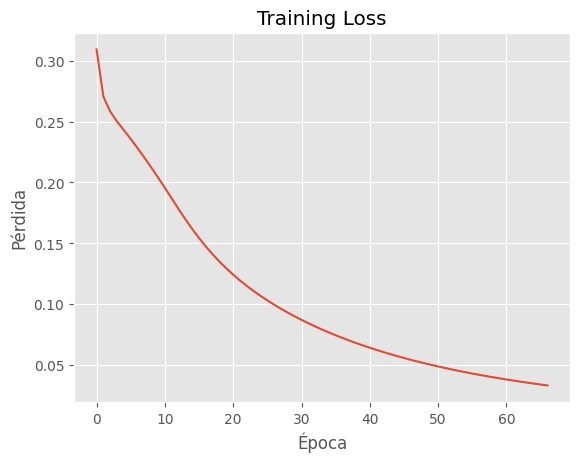

In [ ]:
plt.plot(hist.history["loss"])
plt.title("Training Loss")
plt.xlabel("Época")
plt.ylabel("Pérdida")

Text(0, 0.5, 'Accuracy')

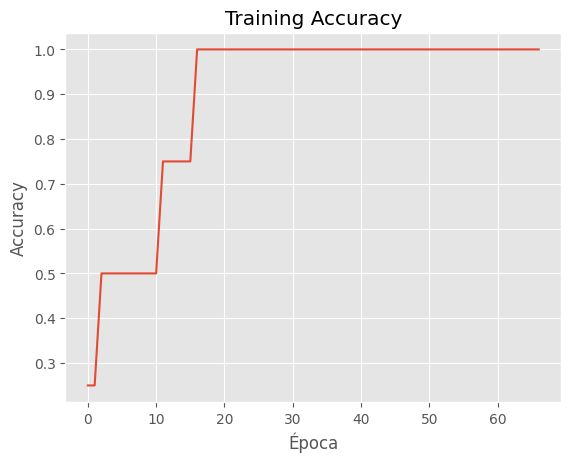

In [ ]:
plt.plot(hist.history["acc"])
plt.title("Training Accuracy")
plt.xlabel("Época")
plt.ylabel("Accuracy")

Como se puede ver en las gráficas, el mejor modelo según el *accuracy* se obtiene alrededor de la `epoch` 30 o 40, y como teníamos una paciencia de 50 `epochs`, se hizo el entrenamiento durante alrededor de 80 o 90 `epochs` en total. En ese punto el `EarlyStopping` actúa y detiene la iteración, evitando que lleguemos a 200 `epochs`.

> **Nota: el número exacto de epochs en la descripción anterior puede cambiar cada vez que se ejecute de nuevo el ejemplo.**

Veamos a continuación los pesos que aprendió el modelo:


In [ ]:
model_fun.layers

[<InputLayer name=input_layer_11, built=True>,
 <Dense name=dense_17, built=True>,
 <Concatenate name=concatenate, built=True>,
 <Dense name=dense_18, built=True>]

In [ ]:
# Neurona intermedia
model_fun.layers[1].weights

[<Variable path=dense_17/kernel, shape=(2, 1), dtype=float32, value=[[2.5344353]
  [2.1516347]]>,
 <Variable path=dense_17/bias, shape=(1,), dtype=float32, value=[-0.6422574]>]

In [ ]:
# Neurona de salida
model_fun.layers[3].weights

[<Variable path=dense_18/kernel, shape=(3, 1), dtype=float32, value=[[-0.946959  ]
  [-0.51813996]
  [ 1.663175  ]]>,
 <Variable path=dense_18/bias, shape=(1,), dtype=float32, value=[-0.2531345]>]

## 2.10 Evaluación

Podemos ver la región de decisión :

  Valor esperado   Valor predicho  
___________________________________
|      0.00       |       0.23      |
|      1.00       |       0.68      |
|      1.00       |       0.60      |
|      0.00       |       0.49      |


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_34']
Received: inputs=Tensor(shape=(10000, 2))
  warnings.warn(msg)


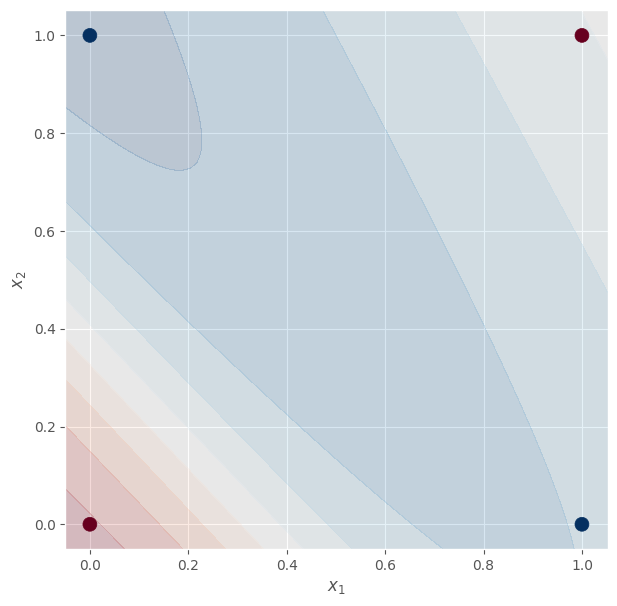

In [ ]:
print_labels(y_XOR, model_fun(X).numpy())
plot_decision_region(X, y_XOR, model_fun)

Y también podemos usar la función `evaluate` sobre el conjunto que queramos probar. `evaluate` recibe dos argumentos:


*   `x`: las observaciones de prueba.
*   `y`: las etiquetas reales de los casos de prueba.


Y nos va a devolver el valor de las métricas que definimos en la compilación, junto con el valor de la función de pérdida, todo evaluado sobre el conjunto que pasemos en `x`:

In [ ]:
model_fun.evaluate(x=X,
               y=y_XOR
               )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 1.0000 - loss: 0.1395


[0.13951723277568817, 1.0]

Tenemos entonces un accuracy de `1.0`.

También podemos usar la función `predict`, que calcula la predicción del modelo sobre un conjunto de observaciones específico. Por ejemplo:

In [ ]:
y_pred = model_fun.predict(x=X)
print(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
[[0.23232765]
 [0.67632633]
 [0.59608394]
 [0.48598352]]


Note que las predicciones de este modelo para cada caso no son completamente binarias, sino un número entre 0 y 1. Recuerde que la salida del modelo es una sola neurona. La asignación final de la etiqueta se hace de acuerdo con si la predicción está más cerca de 0 o de 1. Entonces nos podemos valer de funciones de numpy para hacer esta aproximación, y calcular las etiquetas concretas predichas por el modelo:

In [ ]:
y_pred = np.rint(y_pred)
print(y_pred)

[[0.]
 [1.]
 [1.]
 [0.]]


Con esto podemos usar funciones de _keras_ o de _Scikit-Learn_ para calcular la métrica que queramos. Por ejemplo, podemos calcular un `classification_report` de `sklearn`:

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_XOR, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



O podemos también calcular el _accuracy_ utilizando Keras, usando la clase `keras.metrics.Accuracy`. Para esto hay que definir primero un objeto de la clase, y luego aplicar el método `update_state`, que calcula en efecto la métrica a partir de las etiquetas reales y las predichas por el modelo:

In [ ]:
# Crear el objeto
accuracy = keras.metrics.Accuracy()
# Actualizar la métrica con las etiquetas reales y las predichas por el modelo
accuracy.update_state(y_XOR, y_pred)
# Calcular el acuracy
acc = accuracy.result().numpy()
# Imprimir
print("Accuracy:", acc)

Accuracy: 1.0


# **3. Ejemplo clasificación binaria**
---

Ahora, veamos un ejemplo práctico de la aplicación de una red neuronal. Para ello, utilizaremos un _Dataset_ que contiene características extraídas de imágenes de billetes falsos y auténticos.


<center>
<img src="https://drive.google.com/uc?export=view&id=1-ZUhQlJ-c9HYq5WS6IkWEE0kKouc-_9U" width="50%">
</center>

Se trata de un dataset público conocido como [*banknote authentication Data Set*](https://archive.ics.uci.edu/ml/datasets/banknote+authentication) y contiene cuatro estadísticas de cada imagen y una etiqueta binaria. Comencemos en primer lugar cargando el _Dataset_:

In [ ]:
# Utilizamos pandas para leer el csv con el dataset
!wget = https://drive.google.com/uc?id=10p8a-2FWG7uJkYo8RIht78KVRLuj4OUu
df_bank_note = pd.read_csv('/content/uc?id=10p8a-2FWG7uJkYo8RIht78KVRLuj4OUu', header=None)

--2025-04-01 21:56:16--  http://=/
Resolving = (=)... failed: Name or service not known.
wget: unable to resolve host address ‘=’
--2025-04-01 21:56:16--  https://drive.google.com/uc?id=10p8a-2FWG7uJkYo8RIht78KVRLuj4OUu
Resolving drive.google.com (drive.google.com)... 172.217.218.139, 172.217.218.138, 172.217.218.113, ...
Connecting to drive.google.com (drive.google.com)|172.217.218.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=10p8a-2FWG7uJkYo8RIht78KVRLuj4OUu [following]
--2025-04-01 21:56:16--  https://drive.usercontent.google.com/download?id=10p8a-2FWG7uJkYo8RIht78KVRLuj4OUu
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.143.132, 2a00:1450:4013:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.143.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46400 (45K) [application/octet-stream]
Saving to:

In [ ]:
df_bank_note.head()

,0,1,2,3,4
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [ ]:
# Separamos las características de las etiquetas
X = np.array(df_bank_note.values[1:,:-1],np.float64)
y = np.array(df_bank_note.values[1:,-1],np.float64)

In [ ]:
# Veamos X y su tamaño
X, X.shape

(array([[  4.5459 ,   8.1674 ,  -2.4586 ,  -1.4621 ],
        [  3.866  ,  -2.6383 ,   1.9242 ,   0.10645],
        [  3.4566 ,   9.5228 ,  -4.0112 ,  -3.5944 ],
        ...,
        [ -3.7503 , -13.4586 ,  17.5932 ,  -2.7771 ],
        [ -3.5637 ,  -8.3827 ,  12.393  ,  -1.2823 ],
        [ -2.5419 ,  -0.65804,   2.6842 ,   1.1952 ]]),
 (1371, 4))

In [ ]:
# Veamos y su tamaño
y, y.shape

(array([0., 0., 0., ..., 1., 1., 1.]), (1371,))

Tenemos entonces 1371 muestras de dimensión 4.

## 3.1 Entrenamiento, validación y prueba

La validación o también conocida como _**evaluación fuera de muestra**_ es una técnica de validación estadística de modelos que busca evaluar cómo los resultados de un análisis estadístico se generalizan a un conjunto independiente de datos. Primordialmente, consiste en dividir el conjunto de datos en un conjunto conocido (entrenamiento) que es usado para ajustar los parámetros del modelo y un conjunto de datos desconocido (prueba) que es utilizado para evaluar el desempeño del modelo en datos diferentes a los del entrenamiento.

<center><img src="https://drive.google.com/uc?export=view&id=1hmlQPzhL4zcwTVGQJZ1psrv94GuqsGfr" alt ="Diagrama ilustrativo de la composición de un Dataset" width="60%"></center>

La división de los datos en estos dos conjuntos se debe hacer de forma estratificada, es decir, que el conjunto de entrenamiento y el de prueba tengan las mismas propiedades estadísticas para hacer válida una comparación.


 Vamos a realizar estas particiones del dataset:

In [ ]:
# Dividimos el dataset en: 60% para entrenamiento y 40% para prueba
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, stratify=y
        )

Verifiquemos el tamaño de cada partición:

In [ ]:
X_train.shape

(822, 4)

In [ ]:
X_test.shape

(549, 4)

A diferencia del conjunto de prueba, en el conjunto de validación no necesitamos definirlo explícitamente (aunque también es posible). _Keras_ nos ofrece un parámetro dentro de la función `fit`, llamado `validation_split`, que se encarga de reservar una porción de forma aleatoria (a una razón definida) del conjunto de entrenamiento como conjunto de validación, para evaluar en este pedazo el desempeño del modelo al final de cada `epoch`. El desempeño del modelo se monitorea entonces sobre ese conjunto de validación, es decir, el mejor modelo se escoge según el mejor desempeño que se obtenga en el conjunto de validación.

## 3.2 Modelo

Ahora, definiremos la arquitectura de nuestra red neuronal, como se trata de un problema de clasificación binaria utilizaremos una salida de tipo _sigmoide_ y como función de pérdida la entropía cruzada binaria (similar a la regresión logística).

In [ ]:
# Definimos el modelo
model = keras.models.Sequential()
model.add(
        keras.Input(shape=(4, )) # Definir forma como primera capa
        )
model.add(
        keras.layers.Dense(
            units=32, activation='relu', name="int_layer"
            )
        )
model.add(
        keras.layers.Dense(
            units=1, activation='sigmoid',
            name="out"
            )
        )
# Compilamos el modelo
model.compile(
        loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["acc"]
        )
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ int_layer (Dense)                    │ (None, 32)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ out (Dense)                          │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

Veamos el diagrama:

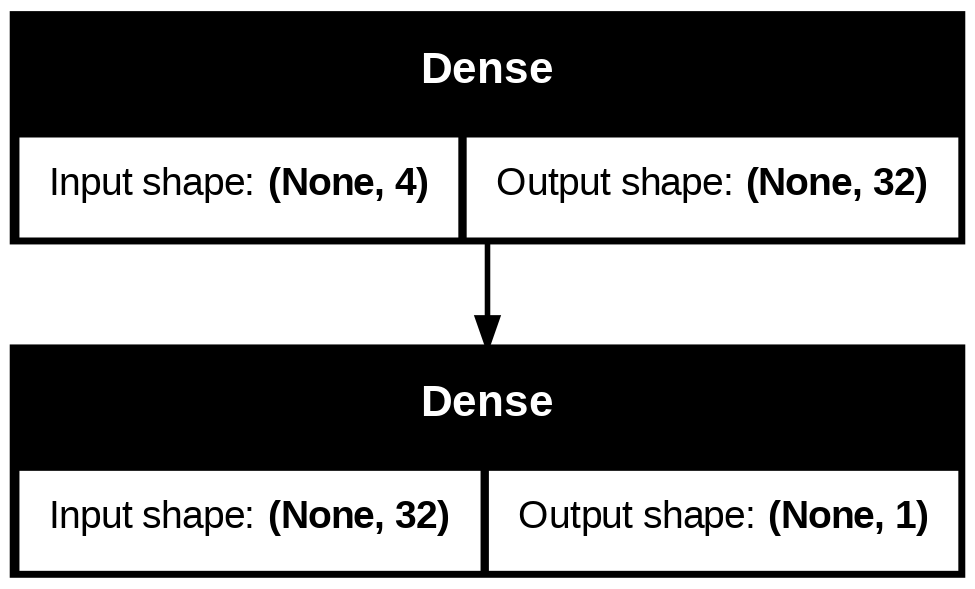

In [ ]:
keras.utils.plot_model(model, show_shapes=True, )

## 3.3 Entrenamiento

Ahora, definimos los *callbacks* y entrenamos el modelo. Note que definimos `validation_split=0.2`. Es decir, en cada `epoch` se reserva el 20% del conjunto de datos de entrenamiento para evaluar al final en ese conjunto la función de pérdida y las métricas que se definieron en la compilación.

In [ ]:
# Definimos Callbacks:
checkpoint = keras.callbacks.ModelCheckpoint(
                  filepath='best_weights_bank.weights.h5',
                  monitor="val_acc",
                  verbose=1,
                  save_best_only=True,
                  save_weights_only=True,
                  mode="max",
            )
stopping = keras.callbacks.EarlyStopping(
                monitor="val_acc",
                patience=10,
                verbose=1,
                mode="max",
                restore_best_weights=True,
            )
# Entrenamos el modelo
hist = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=32,
        validation_split=0.2,
        callbacks=[checkpoint, stopping]
        )

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.5505 - loss: 0.8345
Epoch 1: val_acc improved from -inf to 0.69697, saving model to best_weights_bank.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - acc: 0.5515 - loss: 0.8311 - val_acc: 0.6970 - val_loss: 0.5827
Epoch 2/200
 1/21 ━━━━━━━━━━━━━━━━━━━━ 6s 329ms/step - acc: 0.7500 - loss: 0.5733
Epoch 2: val_acc improved from 0.69697 to 0.93939, saving model to best_weights_bank.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7950 - loss: 0.5262 - val_acc: 0.9394 - val_loss: 0.3878
Epoch 3/200
 1/21 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - acc: 0.9688 - loss: 0.3877
Epoch 3: val_acc improved from 0.93939 to 0.97576, saving model to best_weights_bank.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9453 - loss: 0.3694 - val_acc: 0.9758 - val_loss: 0.2953
Epoch 4/200
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 1.0000 - loss: 0.3071
Epoch 4: val_acc improved from 0.97576 to 1.00000, saving model to best_w

Note que al final de cada `epoch` tenemos cuatro mediciones: `loss`, `acc`, `val_loss` y `val_acc`, que corresponden a los valores de la función de pérdida y del accuracy medidos en el conjunto de entrenamiento y en el conjunto de validación respectivamente.

El comportamiento de todas esas mediciones lo podemos entonces graficar :

Text(0, 0.5, 'Loss')

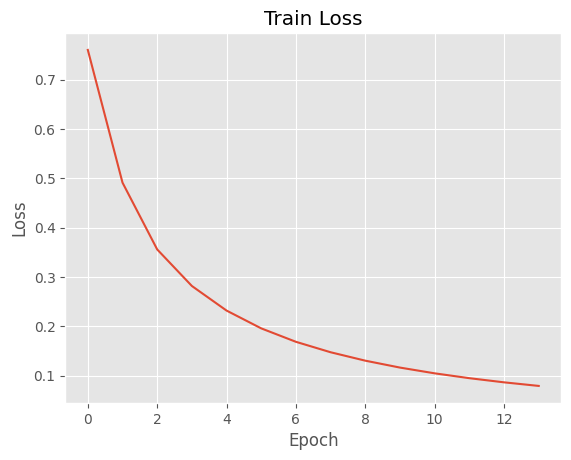

In [ ]:
plt.plot(hist.history["loss"])
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

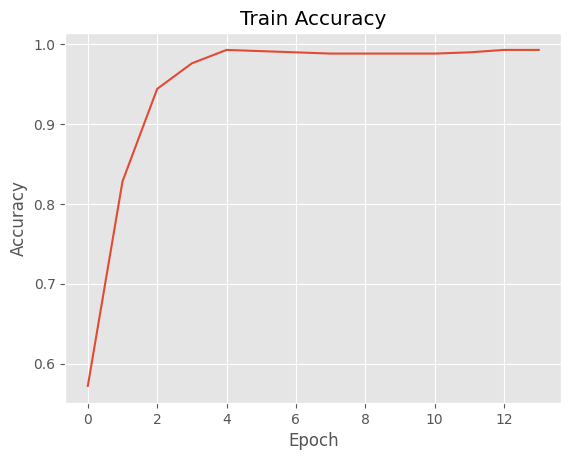

In [ ]:
plt.plot(hist.history["acc"])
plt.title("Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

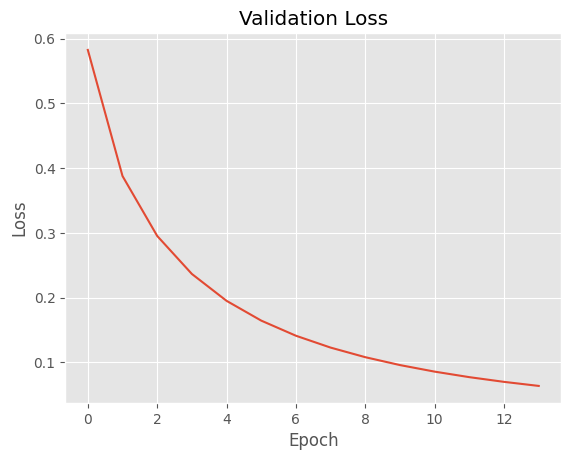

In [ ]:
plt.plot(hist.history["val_loss"])
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

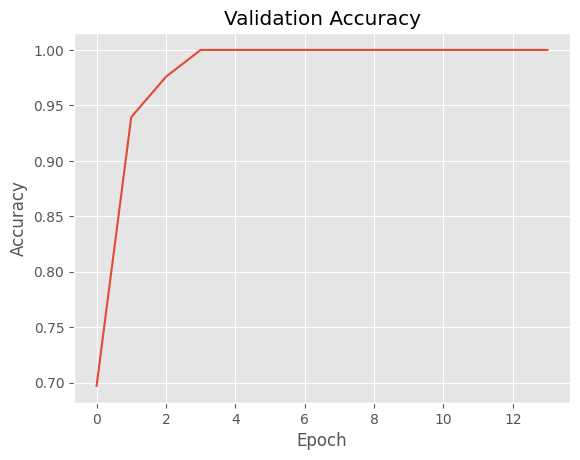

In [ ]:
plt.plot(hist.history["val_acc"])
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

Solo necesitamos alrededor de 30 `epochs` para obtener un buen modelo, según el conjunto de validación. Ahora hay que evaluarlo en el conjunto de prueba.

## 3.4 Evaluación

Ahora miramos el desempeño del modelo en términos de exactitud :

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print("Pérdida en test:",loss)
print("Accuracy en test:",acc)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9889 - loss: 0.2614 
Pérdida en test: 0.26455649733543396
Accuracy en test: 0.9799635410308838


Finalmente, Obtuvimos un accuracy en el conjunto de prueba cercano al 100% **¡Buen trabajo!**

# **Recursos adicionales**
---
Los siguientes enlaces corresponden a sitios en donde encontrará información muy útil para profundizar en el conocimiento de las funcionalidades de *Keras* y la teoría detrás de las redes neuronales:

* [*Neural Network Models (Supervised)*](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)
* [*Introduction to Keras for Engineers*](https://keras.io/getting_started/intro_to_keras_for_engineers/)
* [*Introducción a la Inteligencia Artificial*](https://relopezbriega.github.io/tag/redes-neuronales.html)
* [*Introduction to Deep Learning with Keras*](https://towardsdatascience.com/introduction-to-deep-learning-with-keras-17c09e4f0eb2)

* _Origen de los íconos_
    - Towards Data Science. A Visual Explanation of Gradient Descent Methods [GIF]. https://miro.medium.com/max/1400/1*47skUygd3tWf3yB9A10QHg.gif
    - Keras. Keras Logo [PNG]. https://keras.io/img/logo.png
    - Flaticon. Blocks free icon [PNG]. https://www.flaticon.com/free-icon/lego_302607
    - Flaticon. Blocks free icon [PNG]. https://www.flaticon.com/free-icon/blocks_2466955
    - Onfido Product and Tech. Derivative (gradient) for different values of p [GIF]. https://miro.medium.com/max/640/1*fAHaaT3I003D6tjZQzZ32Q.gif
    - VSH Solutions. Bank note [JPEG]. https://www.vshsolutions.com/wp-content/uploads/2019/02/bankNote1.jpeg